In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

# Use this if running this notebook from within its place in the truera repository.
sys.path.insert(0, "..")

# Or otherwise install trulens.
# !{sys.executable} -m pip install trulens

# Install transformers / huggingface.
!{sys.executable} -m pip install transformers

from IPython.display import display
import torch

# Twitter Sentiment Model

[Huggingface](https://huggingface.co/models) offers a variety of pre-trained NLP models to explore. We exemplify in this notebook a [transformer-based twitter sentiment classification model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). Before getting started, familiarize yourself with the general Truera API as demonstrated in the [intro notebook using pytorch](intro_demo_pytorch.ipynb).

In [4]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Wrap all of the necessary components.
class TwitterSentiment:
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

    # device = 'cpu'
    # Can also use cuda if available:
    device = 'cuda:0'

    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    labels = ['negative', 'neutral', 'positive']

    NEGATIVE = labels.index('negative')
    NEUTRAL = labels.index('neutral')
    POSITIVE = labels.index('positive')

task = TwitterSentiment()

In [5]:
sentences = ["I'm so happy!", "I'm so sad!", "I cannot tell whether I should be happy or sad!", "meh"]

# Input sentences need to be tokenized first.

inputs = task.tokenizer(sentences, padding=True, return_tensors="pt").to(task.device) # pt refers to pytorch tensor

{'input_ids': tensor([[   0,  100,  437,   98, 1372,  328,    2,    1,    1,    1,    1,    1,
            1],
        [   0,  100,  437,   98, 5074,  328,    2,    1,    1,    1,    1,    1,
            1],
        [   0,  100, 1395, 1137,  549,   38,  197,   28, 1372,   50, 5074,  328,
            2],
        [   0, 1794,  298,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}
['<s>', 'I', "'m", ' so', ' happy', '!', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<s>', 'I', "'m", ' so', ' sad', '!', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<s>', 'I', ' cannot', ' tell', ' whether', ' I', ' should', ' be', ' happy', ' or', ' sad', '!', '</s>', '<s>', 'me', 'h', '</s>', '<pad>', '<

In [6]:
from trulens.nn.models import get_model_wrapper
from trulens.nn.quantities import ClassQoI
from trulens.nn.attribution import IntegratedGradients
from trulens.nn.attribution import Cut, OutputCut
from trulens.utils.typing import ModelInputs

task.wrapper = get_model_wrapper(task.model, input_shape=(None, task.tokenizer.model_max_length), device=task.device)

INFO: lib level=1
INFO: root level=30
INFO: Detected pytorch backend for <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>.
INFO: Changing backend from None to Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.
DEBUG: Input dtype was not passed in. Defaulting to `torch.float32`.


In [7]:
task.wrapper.print_layer_names()

'roberta_embeddings_word_embeddings':	Embedding(50265, 768, padding_idx=1)
'roberta_embeddings_position_embeddings':	Embedding(514, 768, padding_idx=1)
'roberta_embeddings_token_type_embeddings':	Embedding(1, 768)
'roberta_embeddings_LayerNorm':	LayerNorm((768,), eps=1e-05, elementwise_affine=True)
'roberta_embeddings_dropout':	Dropout(p=0.1, inplace=False)
'roberta_encoder_layer_0_attention_self_query':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_key':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_value':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_dropout':	Dropout(p=0.1, inplace=False)
'roberta_encoder_layer_0_attention_output_dense':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_output_LayerNorm':	LayerNorm((768,), eps=1e-05, elementwise_affine=True)
'roberta_encoder_layer_0_attention_output_dropou

In [15]:
from trulens.visualizations import NLP

V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=lambda sentences: ModelInputs(kwargs=task.tokenizer(sentences, padding=True, return_tensors='pt')).map(lambda t: t.to(task.device)),
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x.kwargs['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary

    hidden_tokens=set([task.tokenizer.pad_token_id])
    # do not display these tokens
)

In [16]:
from trulens.utils.nlp import token_baseline

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.sep_token_id]),
    # Which tokens to preserve.

    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.

    input_accessor=lambda x: x.kwargs['input_ids'],

    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

In [24]:
layers = []
for l in task.wrapper._layers.keys():
    if l.endswith('_output_dense') and "attention" not in l:
        layers.append(l)
print(layers)

roberta_encoder_layer_0_output_dense
roberta_encoder_layer_1_output_dense
roberta_encoder_layer_2_output_dense
roberta_encoder_layer_3_output_dense
roberta_encoder_layer_4_output_dense
roberta_encoder_layer_5_output_dense
roberta_encoder_layer_6_output_dense
roberta_encoder_layer_7_output_dense
roberta_encoder_layer_8_output_dense
roberta_encoder_layer_9_output_dense
roberta_encoder_layer_10_output_dense
roberta_encoder_layer_11_output_dense
['roberta_encoder_layer_0_output_dense', 'roberta_encoder_layer_1_output_dense', 'roberta_encoder_layer_2_output_dense', 'roberta_encoder_layer_3_output_dense', 'roberta_encoder_layer_4_output_dense', 'roberta_encoder_layer_5_output_dense', 'roberta_encoder_layer_6_output_dense', 'roberta_encoder_layer_7_output_dense', 'roberta_encoder_layer_8_output_dense', 'roberta_encoder_layer_9_output_dense', 'roberta_encoder_layer_10_output_dense', 'roberta_encoder_layer_11_output_dense']


In [26]:
infls = dict()
for l in layers:
    infl = IntegratedGradients(
        model = task.wrapper,
        resolution=50,
        baseline = inputs_baseline_embeddings,
        doi_cut=Cut(l),
        qoi=ClassQoI(task.POSITIVE),
        qoi_cut=OutputCut(accessor=lambda o: o['logits'])
    )
    infls[l] = infl

{'roberta_encoder_layer_0_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a028438>,
 'roberta_encoder_layer_1_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a028d68>,
 'roberta_encoder_layer_2_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a028b70>,
 'roberta_encoder_layer_3_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a028278>,
 'roberta_encoder_layer_4_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a2ffcf8>,
 'roberta_encoder_layer_5_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a06f710>,
 'roberta_encoder_layer_6_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a06f908>,
 'roberta_encoder_layer_7_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a06fd68>,
 'roberta_encoder_layer_8_output_dense': <trulens.nn.attribution.IntegratedGradients at 0x7f117a06fba8>,
 'roberta_encoder_layer_9_output_dense': <trulens.nn.at

In [27]:
attrs = dict()
for l, infl in infls.items():
    attr = infl.attributions(**inputs)
    attrs[l] = attr

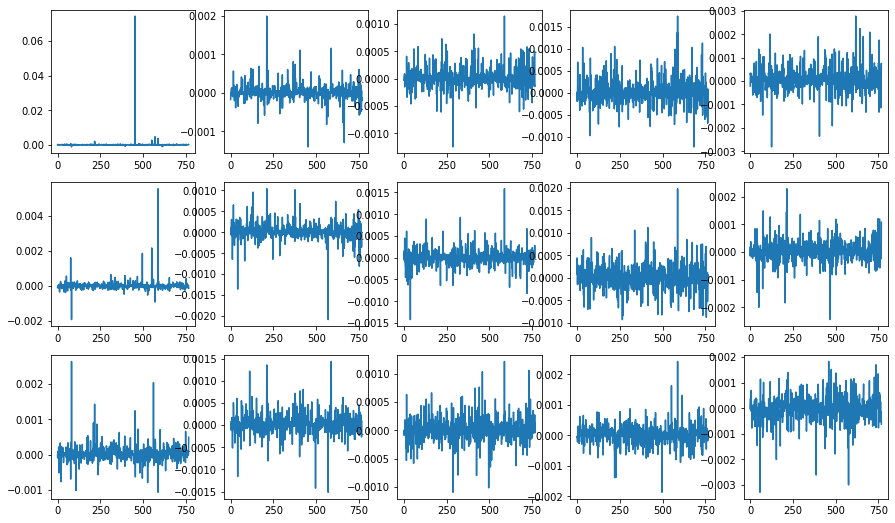

In [55]:
import matplotlib.pyplot as plt

i = 0
input_ids = inputs['input_ids'][i]

fig, axs_2d = plt.subplots(3, 5, figsize=(5*3, 3*3))

for (l, attr), axs_1d in zip(list(attrs.items())[0:3], axs_2d):
    attr = attr[i]
    # print(l, attr.shape)

    for word_id, word_attr, ax in zip(input_ids[0:5], attr[0:5], axs_1d):
        # if word_id < 2: continue
        word = task.tokenizer.decode(word_id)
        # print(word_id, word, word_attr.shape)
        ax.plot(word_attr)

In [32]:
inputs['input_ids'].shape

torch.Size([4, 13])

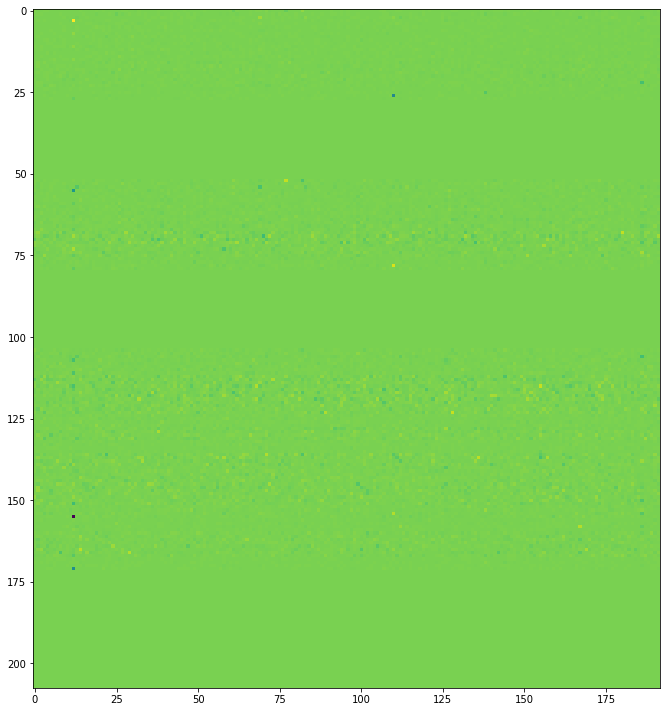

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,10))
ax = fig.subplots(1,1)

ax.imshow(attr2d_norm)
fig.tight_layout()

In [22]:
attr2d_norm.max()

1.0